In [1]:
TRAIN_MODEL = False
OUTPUT_PNG  = False
VISUALIZE   = False
USE_KNN     = False
USE_NAIVE   = True
V_WIDTH     = 100

In [2]:
import torch
import warnings

warnings.filterwarnings("ignore")
DEVICE = torch.device('cuda')

In [3]:
import os

def path_join(arr):
    r = arr[0]
    for i in range(1, len(arr)):
        r = os.path.join(r, arr[i])
    return r

In [4]:
if OUTPUT_PNG:
    from PIL import Image
    import numpy as np

    train = np.load('train.npy', allow_pickle=True)
    for idx, img in enumerate(train):
        img_buf = np.uint8((img + 1) / 2 * 255)
        fig = Image.fromarray(img_buf)
        fig.save(path_join(['images', 'train', f'{idx}.png']))

    test = np.load('test.npy', allow_pickle=True)
    for idx, img in enumerate(test):
        img_buf = np.uint8((img + 1) / 2 * 255)
        fig = Image.fromarray(img_buf)
        fig.save(path_join(['images', 'test', f'{idx}.png']))

In [5]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def __init__(self, size=1024):
        super(UnFlatten, self).__init__()
        self.size = size
    def forward(self, input):
#         print(input.view(input.size(0), self.size, int((input.size(1) / self.size) ** 0.5), -1).shape)
        return input.view(input.size(0), self.size, int((input.size(1) / self.size) ** 0.5), -1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 12, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 96, kernel_size=2, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(75264, 1024),
            nn.ReLU(),
            nn.Linear(1024, z_dim)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(75264, 1024),
            nn.ReLU(),
            nn.Linear(1024, z_dim)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 75264)
        )
        
        self.decoder = nn.Sequential(
            UnFlatten(96),
            nn.ConvTranspose2d(96, 48, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, image_channels, kernel_size=2, stride=1),
            nn.Tanh(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(DEVICE)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(DEVICE)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse + KLD

In [6]:
if VISUALIZE:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1)
    plt.ion()
    fig.show()
    
    def update_line(new_data):
        if not hasattr(update_line, "xs"):
            update_line.xs = []
        if not hasattr(update_line, "ys"):
            update_line.ys = []
        ax.clear()
        if len(update_line.xs) == V_WIDTH:
            update_line.xs = update_line.xs[1:]
        if len(update_line.ys) == V_WIDTH:
            update_line.ys = update_line.ys[1:]
        update_line.xs.append(new_data[0])
        update_line.ys.append(new_data[1])
        ax.plot(update_line.xs, update_line.ys)
        fig.canvas.draw()

In [7]:
if TRAIN_MODEL:
    from torch.utils.data import DataLoader, RandomSampler, TensorDataset
    import numpy as np
    import time

    num_epochs = 200
    batch_size = 128
    learning_rate = 1e-3
    
    train = np.load('train.npy', allow_pickle=True)
    x = train.reshape(len(train), 3, 32, 32)
    
    data = torch.tensor(x, dtype=torch.float)
    train_dataset = TensorDataset(data)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)


    model = VAE().to(DEVICE)
#     model = torch.load('best_model_vae.pt').to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
    )

    best_loss = np.inf
    model.train()
    for epoch in range(num_epochs):
        st_time = time.time()
        for data in train_dataloader:
            img = data[0].to(DEVICE)
            # ===================forward=====================
            output = model(img)
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================save====================
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model, 'best_model_vae.pt')
        # ===================log========================
        if VISUALIZE:
            update_line((epoch+1, loss.item()))
        ed_time = time.time()
        print('epoch [{}/{}], loss:{:.4f}, {:.4f} sec(s)'
              .format(epoch + 1, num_epochs, loss.item(), ed_time - st_time))

In [8]:
if USE_NAIVE:
    from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
    import numpy as np
    
    test = np.load('train.npy', allow_pickle=True)
    y = test.reshape(len(test), 3, 32, 32)
    
    data = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=128)

    model = torch.load('best_model_vae.pt').to(DEVICE)

    model.eval()
    reconstructed = []
    with torch.no_grad():
        for data in test_dataloader:
            output = model(data[0].to(DEVICE))
            output = output[0]
            reconstructed.append(output.cpu().numpy())

    reconstructed = np.concatenate(reconstructed, axis=0)
    
    print(reconstructed.shape)
    print(y.shape)
    
    anomality = np.sqrt(np.sum(np.square(reconstructed - y).reshape(len(y), -1), axis=1))
    y_pred = anomality
    with open('prediction.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))

(40000, 3, 32, 32)
(40000, 3, 32, 32)


In [9]:
if USE_KNN:
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.metrics import f1_score, pairwise_distances, roc_auc_score
    from scipy.cluster.vq import vq, kmeans
    import numpy as np

    def vae_encode(datas):
        model = torch.load('best_model_vae.pt').to(DEVICE)
        model.eval()

        codes = []

        with torch.no_grad():
            data = torch.tensor(datas, dtype=torch.float)
            dataset = TensorDataset(data)

            dataloader = DataLoader(dataset, batch_size=128)
            for data in dataloader:
                img = data[0].to(DEVICE)
                _, mu, lvar = model(img)
                if len(codes) == 0:
                    codes = model.reparametrize(mu, lvar).cpu().numpy()
                else:
                    codes = np.concatenate((codes, model.reparametrize(mu, lvar).cpu().numpy()))
        return codes

    test = np.load('test.npy', allow_pickle=True)
    
    y = test.reshape(len(test), -1)
    y_code = vae_encode(y)

    kmeans_y = MiniBatchKMeans(n_clusters=10, batch_size=1024).fit(y_code)
    y_cluster = kmeans_y.predict(y_code)
    y_dist = np.sum(np.square(kmeans_y.cluster_centers_[y_cluster] - y_code), axis=1)

    y_pred = y_dist
    with open('prediction.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))

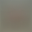

In [10]:
import numpy as np
from PIL import Image

# with torch.no_grad():
#     for data in test_dataloader:
#         output = model(data[0].to(DEVICE))
#         output = output[0]
#         break

Image.fromarray(np.uint8((reconstructed[0].reshape(-1).reshape((32,32,3)) + 1)/2*255))